In [ ]:
!pip install scprep statsmodels magic-impute phate

In [2]:
import scprep

In [ ]:
scprep.io.download.download_google_drive("1IzoUkPcw4yw0oTB9IesoPZOZIUAjONlP", 'r_packages.tar.gz')
!tar xzf r_packages.tar.gz  -C /usr/local/lib/R/site-library/ && rm r_packages.tar.gz
!apt-get install -yqq libgsl-dev=2.4+dfsg-6
!pip install --upgrade rpy2
!R -e "BiocManager::install('splatter')"

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import graphtools as gt

import phate

import scipy.sparse
import sklearn.cluster

from scipy.spatial.distance import pdist, squareform

## Generate Synthetic Data with Known Ground Truth

### Introduction to Splatter

Splatter, [Zappia L, et al. Genome Biology. 2017](https://doi.org/10.1186/s13059-017-1305-0), is a tool for simulating single-cell RNA-sequencing data with a known topology. Splatter has two main modes: "`paths`" and "`groups`." Because we're interested in generating data with a known trajectory structure, we are going to use the `paths` mode.

Splatter has a bunch of other parameters you can choose from, and if you have time, feel free to play around with the various options.



#### Generating simulated data

Splatter is only implemented in R. Fortunately, we provide a wrapper in the `scprep.run` module. You can call Splatter from Python using [`scprep.run.SplatSimulate()`](https://scprep.readthedocs.io/en/stable/reference.html#scprep.run.SplatSimulate).

In [5]:
# Run Splatter

# You can easily change the number of paths and cells here
n_paths = 3
cells_per_path = 1000

# Splatter returns a `dict` objbect that contains a bunch of useful information
results = scprep.run.SplatSimulate(
                        method='paths', 
                        batch_cells=cells_per_path * n_paths, 
                        group_prob=np.tile(1/n_paths, n_paths), 
                        n_genes=5000,
                        de_down_prob=0.5,
                        path_from=[0,0,0],
                        mean_shape=1,
                        seed=0)

R[write to console]: Getting parameters...
R[write to console]: Creating simulation object...
R[write to console]: Simulating library sizes...
R[write to console]: Simulating gene means...
R[write to console]: Simulating path endpoints...
R[write to console]: Simulating path steps...
R[write to console]: Simulating BCV...
R[write to console]: Simulating counts...
R[write to console]: Simulating dropout (if needed)...
R[write to console]: Done!


Let's check what we can find in this `results` dictionary. Note, you can find explanations of what each key refers to by checking the `returns` section of the `SplatSimulate` docstring or consulting https://scprep.readthedocs.io/en/stable/reference.html#scprep.run.SplatSimulate.

In [6]:
results.keys()

dict_keys(['counts', 'group', 'step', 'batch', 'exp_lib_size', 'base_gene_mean', 'outlier_factor', 'batch_cell_means', 'base_cell_means', 'bcv', 'cell_means', 'true_counts', 'dropout', 'de_fac_1', 'de_fac_2', 'de_fac_3', 'sigma_fac_1', 'sigma_fac_2', 'sigma_fac_3'])

There's a lot of organizational stuff happening in the next code block. The key idea is that we want to grab three pieces of information from `results`:
* `counts` - simulated expression counts
* `group` - the group or path the cell belongs to
* `step` - how far along the path each cell is

We're putting `counts` into one DataFrame and `group` & `step` in a separate DataFrame. Then we do some manipulation of the `step` vector so it increases monotonically (as opposed to restarting at 0 at the beginning of each path). Finally we change the name of the `Index` of `data` and `metadata` and preprocess the data.

In [7]:
# Put counts data in DataFrame
data = pd.DataFrame(results['counts'])
data.head()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,4,94,1,2,0,12,3,7,5,1,...,10,1,6,1,0,0,1,6,0,0
1,2,77,0,1,1,9,7,2,1,0,...,10,1,3,1,2,0,8,2,1,6
2,1,77,4,5,0,3,9,0,1,0,...,9,0,8,3,0,0,0,3,0,2
3,1,79,3,4,0,10,8,4,0,2,...,4,1,14,3,0,1,1,6,1,11
4,0,69,5,8,0,10,12,5,0,1,...,5,0,4,3,0,0,1,4,3,1


In [8]:
# Put metadata in a DataFrame
metadata = pd.DataFrame({'group':results['group'], 'step':results['step'].astype(int)})

# clean up group labels from e.g. Path3 to 3
metadata['group'] = metadata['group'].str[4:].astype(int)

metadata.head()

,group,step
0,2,52
1,1,48
2,3,32
3,3,20
4,2,12


At the moment, we have a `group` marker that tells us which branch we're on (1/2/3) and a `step` marker that tells us where we are on each branch (1-100). We want a single, global position vector, so we'll set `step` to range from 1-100 on branch 1 and from 101-200 on branches 2 and 3.

In [9]:
# Adjusting the 'step' vector to monotonically increase
p1_mask = metadata['group'] == 1
metadata.loc[p1_mask, 'step'] = 100 - metadata.loc[p1_mask, 'step']
p23_mask = np.isin(metadata['group'], [2,3])
metadata.loc[p23_mask, 'step'] = 100 + metadata.loc[p23_mask, 'step']
metadata.head()

,group,step
0,2,152
1,1,52
2,3,132
3,3,120
4,2,112


Finally, let's rename the cells for clarity, and preprocess the data.

In [10]:
# Change DataFrame index names to be a little nicer
new_index = pd.Index(['cell_{}'.format(i) for i in range(metadata.shape[0])])
data.index = new_index
metadata.index = new_index

# Library-size normalize and sqrt transform
data = scprep.normalize.library_size_normalize(data)
data = scprep.transform.sqrt(data)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
cell_0,0.818751,3.969044,0.409376,0.578945,0.000000,1.418119,0.709059,1.083106,0.915392,0.409376,...,1.294559,0.409376,1.002761,0.409376,0.000000,0.000000,0.409376,1.002761,0.000000,0.000000
cell_1,0.578673,3.590572,0.000000,0.409184,0.409184,1.227551,1.082598,0.578673,0.409184,0.000000,...,1.293952,0.409184,0.708727,0.409184,0.578673,0.000000,1.157346,0.578673,0.409184,1.002291
cell_2,0.417352,3.662248,0.834704,0.933227,0.000000,0.722875,1.252056,0.000000,0.417352,0.000000,...,1.252056,0.000000,1.180450,0.722875,0.000000,0.000000,0.000000,0.722875,0.000000,0.590225
cell_3,0.349678,3.108007,0.605660,0.699356,0.000000,1.105779,0.989039,0.699356,0.000000,0.494520,...,0.699356,0.349678,1.308376,0.605660,0.000000,0.349678,0.349678,0.856533,0.349678,1.159751
cell_4,0.000000,3.505747,0.943715,1.193716,0.000000,1.334615,1.461998,0.943715,0.000000,0.422042,...,0.943715,0.000000,0.844085,0.730999,0.000000,0.000000,0.422042,0.844085,0.730999,0.422042


#### Visualizing the data

Splatter is designed to generate data that can be easily visualized using PCA. If you have time, try to visualize the data using other tools from our visualization module.

In [11]:
data_pca = scprep.reduce.pca(data)

Plot the data using `scprep.plot.scatter2d()`.

<AxesSubplot:title={'center':'PCA'}, xlabel='PC1', ylabel='PC2'>

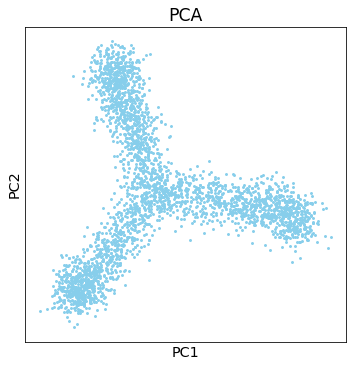

In [12]:
scprep.plot.scatter2d(data_pca, color='skyblue',
                      ticks=None, title='PCA', 
                      label_prefix='PC',
                      figsize=(5,5.2))

#### Plot the `step` vector

<AxesSubplot:title={'center':'PCA'}, xlabel='PC1', ylabel='PC2'>

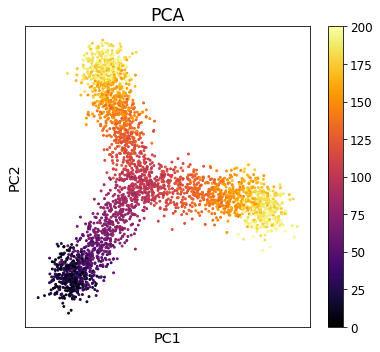

In [13]:
scprep.plot.scatter2d(data_pca, c=metadata['step'],
                      ticks=None, title='PCA', 
                      label_prefix='PC',
                      figsize=(5.5,5))

#### Plot the `group` vector

<AxesSubplot:title={'center':'PCA'}, xlabel='PC1', ylabel='PC2'>

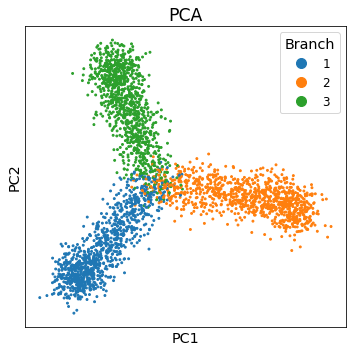

In [14]:
scprep.plot.scatter2d(data_pca, c=metadata['group'],
                      legend_title='Branch',
                      ticks=None, title='PCA', 
                      label_prefix='PC',
                      figsize=(5,5))

#### Assign each cell to a day using a binomal distribution

To make it easier to understand the benefit of pseudotime analysis, we're going to assign each cell to a sample labelled `Day1`, `Day2`, or `Day3` to mimic a traditional time course experiment. Note that we're not using the `counts` data to do this, but rather we're using the _latent variable_ `step` to assign samples. This means the we're using the same latent variable to generate counts and independently generate the `sample` labels.

In [15]:
# This random distribution will have increased probability of generating a `2` 
# as the `step` gets larger.
normalized_step = metadata['step'] / metadata['step'].max()
sample = np.random.binomial(n = 2,
                            p = normalized_step, 
                            size=metadata.shape[0]) + 1


sample_cmap = {1 : 'lightgreen',
       2: 'skyblue',
       3: 'darkblue'}

<AxesSubplot:title={'center':'Day of sample collection'}, xlabel='PC1', ylabel='PC2'>

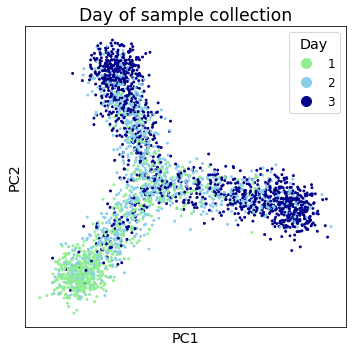

In [16]:
scprep.plot.scatter2d(data_pca,  c=sample, cmap=sample_cmap,
                      legend_title='Day',
                      label_prefix='PC',
                      ticks=None, title='Day of sample collection', 
                      legend=True, figsize=(5,5))

## 2. Learning Diffusion Pseudotime (DPT)

In this section, we're going to run diffusion pseudotime (DPT) from scratch. Yes, there is a nice wrapper we will use later. For now, we want to show you _how_ DPT is calculated.

#### The math
Remember from lecture that the following two equations define DPT:
$$ \textrm{DPT}(x,y) = ||\mathbf{M}(x,:) - \mathbf{M}(y,:)||, ~\mathbf{M} = \sum\limits_{t=1}^{\infty}\mathbf{\tilde{T}}$$
$$ \mathbf{M} = \sum\limits_{t=1}^{\infty}\mathbf{\tilde{T}} = (I-\mathbf{\tilde{T}})^{-1}-I ~\textrm{where}~ \mathbf{\tilde{T}} = \mathbf{T} - \psi_0\psi_0^T$$

Here, $\mathbf{T}$ is the diffusion operator (defined below), $I$ is the identity matrix, and $\psi_0$ is the first eigenvector of $\mathbf{T}$. You can actually derive all the steps of DPT from these two equations by reading backwards.

The first step is to calculate $\mathbf{\tilde{T}} = \mathbf{T} - \psi_0\psi_0^T$. From this we can reason that we need to learn a graph, calculate a diffusion operator, get the first eigenvector of that diffusion operator, and subtract that from $\mathbf{T}$.

Next, we need to calculate $\mathbf{M}$ using these equations $ \mathbf{M} = \sum\limits_{t=1}^{\infty}\mathbf{\tilde{T}} = (I-\mathbf{\tilde{T}})^{-1}-I$. There's a lot going on there, but remember that if $a = b = c$ then $a=c$ so we really only care that $ \mathbf{M} = (I-\mathbf{\tilde{T}})^{-1}-I$.

Once we have $\mathbf{M}$, we can easily get the DPT between any two points $x,y$ by subtracting the relevant rows of $\mathbf{M}$.

#### The algorithm

Having gone through all that, we can break down DPT into the following steps:
1. Learn a graph from the data using local Euclidean distances
2. Subtract the first diffusion operator eigenspace from the transition probabilities
3. Calculate the limit of all random walks on the graph
4. Calculate pairwise distances in the random walk space



### Step 1 - Learn a graph from the counts data 

Here, we're using `graphtools` to learn a graph from data. If you remember from the manifold learning section, the key to learning a graph from data is to calculate _local Euclidean distances_ and then connect cells that are in the same _neighborhood_. We can do this in one line by calling `gt.Graph()`.  We have loaded `graphtools` during the initial `import` statements in this notebook.

The full graphtools API can be found here: https://graphtools.readthedocs.io/en/stable/reference.html#module-graphtools.api

In [17]:
G = gt.Graph(data, n_pca=100, use_pygsp=True)

### Step 2 - Subtract the first diffusion operator eigenspace from the transition probabilities

Now, we know that even though eigenvectors are important, they are incredibly abstract and confusing. The more important concept here is to understand the **diffusion operator**. The diffusion operator is so useful that it is calculated whenever you build a graph with `graphtools`.

The diffusion operator is usually defines as "the row-stochastic form of the kernel matrix." The key terms here are:
* kernel matrix, $\mathbf{K}$ - the matrix of size $n \times n$ where $n$ is the number of vertices in the graph. Each entry $\mathbf{K}_{i,j}$ contains the weight of the edge connecting vertex $i$ and vertex $j$.
* row-stochastic - this is a fancy term to describe the fact that each row of a matrix sums to $1$.

A row-stochastic kernel matrix has edge weights scaled such that they could represent the **transition probability** of moving from one vertex to another. This is the heart of the "random-walk" along a graph. If you Google "[graph random walk](https://www.google.com/search?q=graph+random+walk&oq=graph+random+walk)", you'll find a ton a resources on the topic.

Let's compare the row-sums of `G.K`, the kernel matrix, and `G.diff_op`, the diffusion operator.

In [18]:
# ====================
# Which axis do we need to sum across to get the row-sum?
axis = 1
# ====================
print(G.K.sum(axis=axis))
print(G.diff_op.sum(axis=axis))

[[ 2.95414014]
 [ 4.20305275]
 [ 2.87340483]
 ...
 [ 5.57537928]
 [11.85079711]
 [10.10467594]]
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]


By default, `G.diff_op` is a sparse matrix, because so many entries are `0`. You can confirm this using `type(G.diff_op)` which should return `scipy.sparse.csr.csr_matrix`. This means we can calculate the first eigenvector efficiently using `scipy.sparse.linalg.eigs()`.

To turn an eigenvector into an eigenspace, we take the [_inner product_](http://mathworld.wolfram.com/InnerProduct.html) using the `@` operator. We can then subtract this matrix from `G.diff_op`.

In [19]:
# If you look at the top, we already imported the `sparse` module from `scipy`
W, V = scipy.sparse.linalg.eigs(G.diff_op, k=1)

# W is the eigenVALUE matrix and V is the eigenVECTOR matrix
# We only care about eigenVECTORS here
V_0 = V @ V.T

# Now we can subtract this from G.diff_op
T_tilde = G.diff_op.toarray() - (V[:,0] @ V[:,0].T)

### Step 3 - Calculate $\mathbf{M}$, the limit of all random walk distances on the graph

Here, we're calculating $ \mathbf{M} = \sum\limits_{t=1}^{\infty}\mathbf{\tilde{T}} = (I-\mathbf{\tilde{T}})^{-1}-I$. This is a fairly simple calculation, especially now that we have $\tilde{T}$ calculated. The only think you might not be familiar with here is that $^{-1}$ operation which is a [_matrix inverse_](http://mathworld.wolfram.com/MatrixInverse.html). All you need to know for now is that you can calculate this with `np.linalg.inv()`.

In [20]:
# Create the identity matrix the same size as T_tilde
I = np.eye(T_tilde.shape[1])

# Do the matrix inversion
M = np.linalg.inv(I - T_tilde) - I
# Discard imaginary component of M
M = np.real(M)

### Step 4 - Calculate DPT between all pairs of points

This should be the simplest step as we've already gone over how to calculate pairwise distances. Instead of calculating Euclidean distances on the raw data, we're doing it on $\mathbf{M}$.

In [21]:
# Calc DPT
DPT = pd.DataFrame(squareform(pdist(M)), index=data.index, columns=data.index)
DPT.head()

,cell_0,cell_1,cell_2,cell_3,cell_4,cell_5,cell_6,cell_7,cell_8,cell_9,...,cell_2990,cell_2991,cell_2992,cell_2993,cell_2994,cell_2995,cell_2996,cell_2997,cell_2998,cell_2999
cell_0,0.000000,3.555959,2.929335,2.796661,2.129916,2.791224,1.198287,1.708186,4.174903,4.430505,...,1.748304,4.395377,2.922999,4.166252,2.524239,1.391014,3.233800,3.518046,3.369371,3.514324
cell_1,3.555959,0.000000,2.690229,2.587512,2.285985,1.295877,3.985481,2.614128,3.966210,4.230721,...,4.602896,4.193938,2.661034,3.958042,2.201681,2.922582,0.765594,0.738821,0.641328,0.584290
cell_2,2.929335,2.690229,0.000000,0.889680,1.583884,1.782184,3.383123,1.889968,2.107503,2.447517,...,4.055178,2.383543,1.068643,2.097961,1.171327,2.215359,2.298395,2.638810,2.453252,2.621519
cell_3,2.796661,2.587512,0.889680,0.000000,1.379067,1.629168,3.262435,1.711543,2.155513,2.498108,...,3.945980,2.435446,0.945286,2.146273,0.963989,2.055276,2.179719,2.534538,2.343186,2.519866
cell_4,2.129916,2.285985,1.583884,1.379067,0.000000,1.296715,2.615250,1.108847,3.086629,3.392836,...,3.312020,3.346898,1.577293,3.077341,1.014893,1.425843,1.874034,2.234061,2.045407,2.223186


### Putting it all in a single function

To hammer home how simple these steps are, let's put all of them in one convenience function.

In [22]:
def calculateDiffusionPseudotime(data):
    '''Calculates DPT between all points in the data'''

    G = gt.Graph(data, n_pca=100, use_pygsp=True)
    
    # Calculate eigenvectors of the diffusion operator
    # May be faster way to do this
    W, V = scipy.sparse.linalg.eigs(G.diff_op, k=1)
    
    # Remove first eigenspace
    T_tilde = G.diff_op.toarray() - (V[:,0] @ V[:,0].T)
    
    # Calculate M
    I = np.eye(T_tilde.shape[1])
    M = np.linalg.inv(I - T_tilde) - I
    M = np.real(M)
    
    # Calc DPT
    DPT = squareform(pdist(M))
    
    DPT = DPT
    return DPT

### Picking a root cell

If you remember, diffusion pseudotime requires the user to input a **root cell**. There is some guidance in the Diffusion Pseudotime paper on how to pick a root cell, but for the most part it requires some prior assumptions about the data. Here, we can return to our simulated data and figure out some way to pick the root.

<AxesSubplot:title={'center':'Day of Sample Collection'}, xlabel='PC1', ylabel='PC2'>

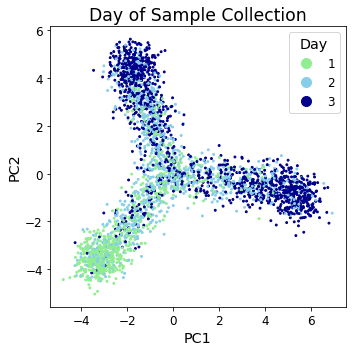

In [23]:
scprep.plot.scatter2d(data_pca, c=sample, cmap=sample_cmap, 
                      title='Day of Sample Collection', 
                      legend=True, label_prefix='PC', legend_title='Day',
                      figsize=(5,5))

#### Using PC1

On the first branch of the data, it looks like PC1 does a pretty good job of tracking with the developmental progression. Let's take the cell with the lowest PC1 value for the root cell. We'll plot that cell in red.

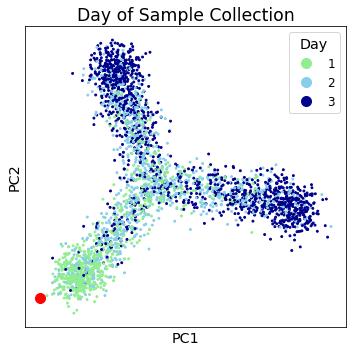

In [24]:
# Selecting the root cell
root_cell = data_pca['PC1'].idxmin()

# Plotting the rest of the cells
ax = scprep.plot.scatter2d(data_pca, c=sample, cmap=sample_cmap,
                           title='Day of Sample Collection',
                           legend=True, label_prefix='PC',
                           legend_title='Day',
                           ticks=None,
                           figsize=(5,5))

# Plotting the root cell
ax.scatter(data_pca.loc[root_cell]['PC1'], data_pca.loc[root_cell]['PC2'],
                         c='red', s=100, zorder=2)

#### Plotting DPT from the root cell to  all other cells

Because $ \textrm{DPT}(x,y) = ||\mathbf{M}(x,:) - \mathbf{M}(y,:)||$, we can now take rows of the `DPT` matrix we calculated earlier to get a pseudotemporal ordering of cells.

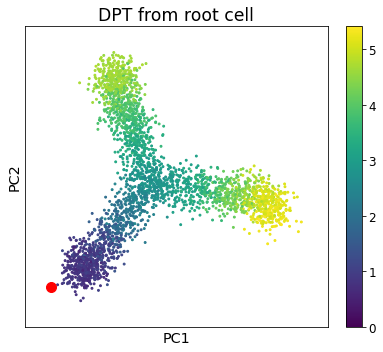

In [25]:
# Plotting the rest of the cells
ax = scprep.plot.scatter2d(data_pca, c=DPT.loc[root_cell], cmap='viridis',
                           title='DPT from root cell',
                           legend=True, label_prefix='PC',
                           ticks=False,
                           figsize=(5.8,5))

# Plotting the root cell
ax.scatter(data_pca.loc[root_cell]['PC1'], data_pca.loc[root_cell]['PC2'],
                         c='red', s=100, zorder=2)

#### Comparing DPT to latent `step` variable

Finally, we can compare DPT to the latent variable `step` that was used to generate the data to determine how accurately the method captures ground truth.

**Note:** You will need to add code for the x and y axis.

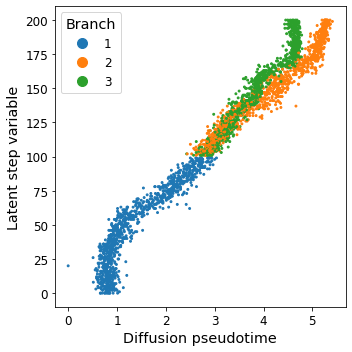

In [26]:
ax = scprep.plot.scatter(
            # =========
            # plot diffusion pseudotime on the x-axis and the metadata 'step'
            # variable on the y-axis
            x = DPT.loc[root_cell],
            y = metadata['step'],
            # ========= 
            c=metadata['group'],
            xlabel='Diffusion pseudotime', ylabel='Latent step variable',
            legend_title='Branch', figsize=(5,5))

What conclusions do you draw from this?

### Examining gene trends with DPT

In a later section, we'll go over how to select the genes that are the most correlated with pseudotime, but for now, let's cheat. The `results` returned from `SplatSimulate` contains arrays that tell us how differentially expressed on each branch. They are `de_fac_1`, `de_fac_2`, `de_fac_3`.

We're going to use `np.argsort()` to get the gene indices that have the highest level of differential expression on average across all genes.

**Comprehension question:** what does `[::-1]` do?

In [27]:
# Change this to switch which branch we want to look at
branch_of_interest = 1

# This line sorts all simulated genes
de_factors = pd.DataFrame([results['de_fac_1'] - 1, results['de_fac_2'] - 1, results['de_fac_3'] - 1]).T

most_de_genes = np.argsort(de_factors.abs().mean(axis=1).values)[::-1]
least_de_genes = np.argsort(de_factors.abs().mean(axis=1).values)

In [28]:
from statsmodels.nonparametric.smoothers_lowess import lowess
import magic

#### Running MAGIC

In [29]:
data_magic = magic.MAGIC().fit_transform(data)

Calculating MAGIC...
  Running MAGIC on 3000 cells and 5000 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...


/home/scottgigante/.local/lib/python3.8/site-packages/magic/magic.py:471: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.
  warnings.warn(


    Calculated PCA in 1.05 seconds.
    Calculating KNN search...
    Calculated KNN search in 1.15 seconds.
    Calculating affinities...
    Calculated affinities in 1.15 seconds.
  Calculated graph and diffusion operator in 3.42 seconds.
  Calculating imputation...


/home/scottgigante/.local/lib/python3.8/site-packages/magic/magic.py:500: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  and isinstance(X, (pd.SparseDataFrame, sparse.spmatrix))


  Calculated imputation in 0.85 seconds.
Calculated MAGIC in 4.43 seconds.


/home/scottgigante/.local/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


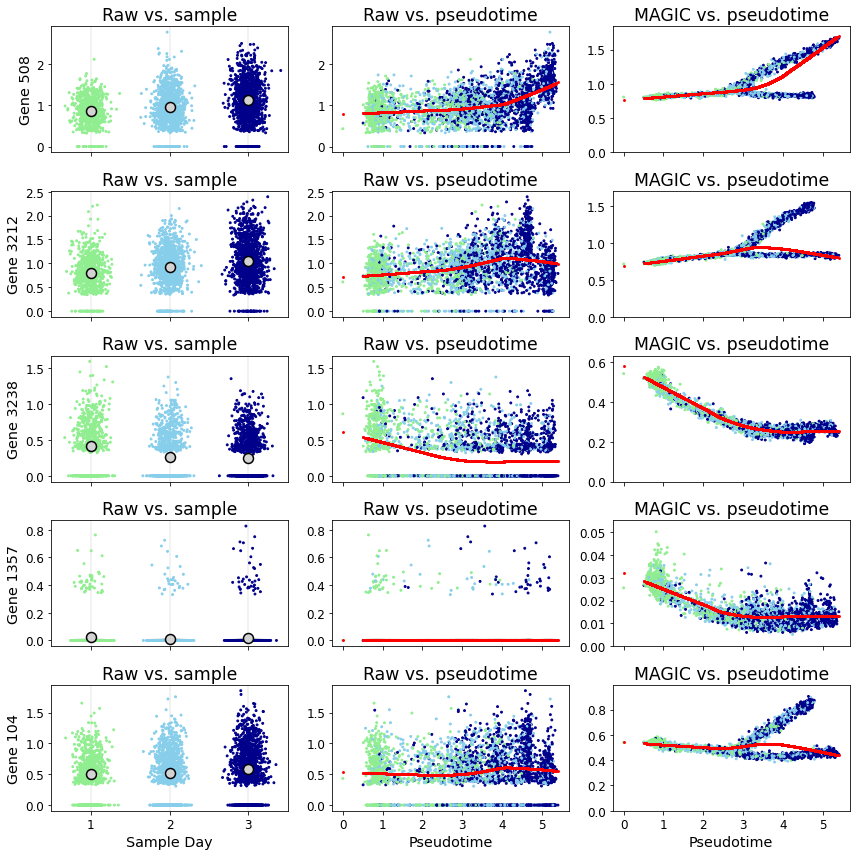

In [30]:
fig, axes = plt.subplots(5,3, figsize=(12,12), sharex='col')

for i, ax_row in enumerate(axes):
    gene = data.iloc[:, most_de_genes[i]]    
    gene_magic = data_magic.iloc[:, most_de_genes[i]]

    ax_left, ax_mid, ax_right = ax_row
    
    scprep.plot.jitter(sample, gene, c=sample, cmap=sample_cmap,
                       title='Raw vs. sample',
                       legend=False,
                       xlabel=False,
                       ylabel="Gene {}".format(most_de_genes[i]),
                       ax=ax_left)
    # Plotting raw data
    scprep.plot.scatter(DPT.loc[root_cell], gene, 
                        c=sample, cmap=sample_cmap,
                        title='Raw vs. pseudotime',
                        xlabel=False,
                        ylabel=False,
                        legend=False,
                        ax=ax_mid)
    
    # Plot a loess curve
    smooth_expression = lowess(gene, DPT.loc[root_cell], return_sorted=False)
    scprep.plot.scatter(DPT.loc[root_cell], smooth_expression, 
                         c='red',
                        xlabel=False,
                        ylabel=False,
                        ax=ax_mid)
                        
   # Plotting MAGIC data
    scprep.plot.scatter(DPT.loc[root_cell], gene_magic, 
                         c=sample, cmap=sample_cmap,
                        title='MAGIC vs. pseudotime',
                        legend=False,
                        xlabel=False,
                        ylabel=False,
                        ax=ax_right)
    
    # Plot a loess curve
    smooth_expression = lowess(gene_magic, DPT.loc[root_cell], return_sorted=False)
    scprep.plot.scatter(DPT.loc[root_cell], smooth_expression, 
                         c='red',
                        xlabel=False,
                        ylabel=False,
                        ax=ax_right)
    ax_right.set_ylim(0, np.max(gene_magic) * 1.1)

axes[-1][0].set_xlabel("Sample Day", fontsize='x-large')
axes[-1][1].set_xlabel("Pseudotime", fontsize='x-large')
axes[-1][2].set_xlabel("Pseudotime", fontsize='x-large')
fig.tight_layout()

### Exercise

The above code block plots the 5 most differentially expressed genes on average across all branches.  

In groups:
1. Duplicate the code block
2. Change the code so the *least* differentially expressed genes are ploted (Hint: what end of the `most_de_genes` will these genes be on?
3. Generate the plot.


If you have time, try adding more rows in the call to `plt.subplots()`. This will take more time to run, but will show you more information.

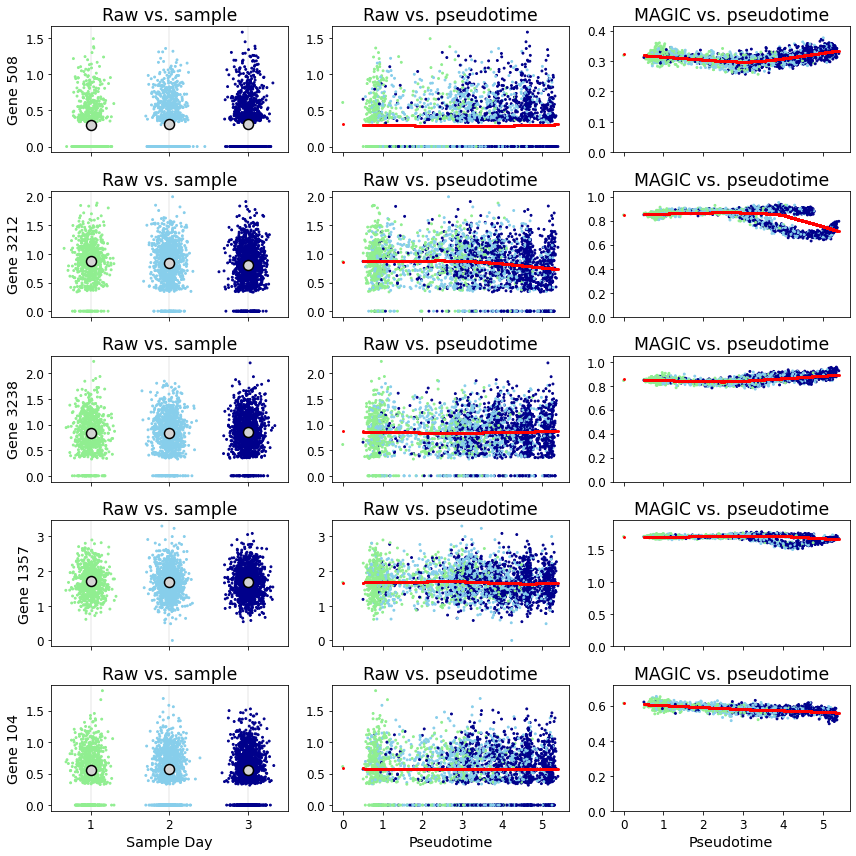

In [31]:
fig, axes = plt.subplots(5,3, figsize=(12,12), sharex='col')

for i, ax_row in enumerate(axes):
    gene = data.iloc[:, most_de_genes[-i-1]]    
    gene_magic = data_magic.iloc[:, most_de_genes[-i-1]]

    ax_left, ax_mid, ax_right = ax_row
    
    scprep.plot.jitter(sample, gene, c=sample, cmap=sample_cmap,
                       title='Raw vs. sample',
                       legend=False,
                       xlabel=False,
                       ylabel="Gene {}".format(most_de_genes[i]),
                       ax=ax_left)
    # Plotting raw data
    scprep.plot.scatter(DPT.loc[root_cell], gene, 
                        c=sample, cmap=sample_cmap,
                        title='Raw vs. pseudotime',
                        xlabel=False,
                        ylabel=False,
                        legend=False,
                        ax=ax_mid)
    
    # Plot a loess curve
    smooth_expression = lowess(gene, DPT.loc[root_cell], return_sorted=False)
    scprep.plot.scatter(DPT.loc[root_cell], smooth_expression, 
                         c='red',
                        xlabel=False,
                        ylabel=False,
                        ax=ax_mid)
                        
   # Plotting MAGIC data
    scprep.plot.scatter(DPT.loc[root_cell], gene_magic, 
                         c=sample, cmap=sample_cmap,
                        title='MAGIC vs. pseudotime',
                        legend=False,
                        xlabel=False,
                        ylabel=False,
                        ax=ax_right)
    
    # Plot a loess curve
    smooth_expression = lowess(gene_magic, DPT.loc[root_cell], return_sorted=False)
    scprep.plot.scatter(DPT.loc[root_cell], smooth_expression, 
                         c='red',
                        xlabel=False,
                        ylabel=False,
                        ax=ax_right)
    ax_right.set_ylim(0, np.max(gene_magic) * 1.1)

axes[-1][0].set_xlabel("Sample Day", fontsize='x-large')
axes[-1][1].set_xlabel("Pseudotime", fontsize='x-large')
axes[-1][2].set_xlabel("Pseudotime", fontsize='x-large')
fig.tight_layout()

### Discussion

1. What do you notice about the relationship between gene expression and pseudotime? 
    - It's hard to see much happening in the raw gene expression, except where the mean gene expression changes between samples (in which case we can just use the jitterplot and ignore the pseudotime.) With the MAGIC gene expression, we can see clear distinctions between branches when comparing to pseudotime.
2. Do you see anything subtle happening with the MAGIC values on the least differentially expressed genes? Why do you think this is happening?
    - Even though these are the least DE genes, we still sometimes see difference between branches. This is likely due to the randomness in the gene expression being enhanced by MAGIC's smoothing. This effect will get stronger the more smoothing we do.
3. Why are the MAGIC expression values on a different scale to the raw expression values?
    - Since most of the raw expression values are zero, which MAGIC smooths across similar cells, in takes a weighted average of non-zero and zero expression values, decreasing the value of the non-zeros and increasing the value of the zeros, reducing the range of the overall expression.

<div id='calculating-branches'></div>

## Calculating branches using correlation

The next major step in DPT is identifying branches using the correlation/anti-correlation between forward and reverse pseudotime. We already have forward pseudotime. To get reverse pseudotime we perform the following steps:
1. Identify the "end cell" farthest (in DPT) from the root cell
2. Calculate the distance to the "end cell" for each cell in the dataset

We'll start by picking the end cell and plotting it against forward pseudotime, with the root cell in red and the end cell in blue.

In [32]:
# The cell with the highest DPT from the root cell is the end_cell
end_cell = DPT.loc[root_cell].idxmax()

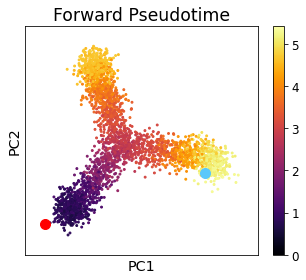

In [33]:
# Plot forward pseudotime
ax = scprep.plot.scatter2d(data_pca, c = DPT[root_cell], 
                      ticks=None, title='Forward Pseudotime', 
                      discrete=False, legend=True,label_prefix='PC',
                      figsize=(4.6,4))

# Plot the root cell
ax.scatter(data_pca.loc[root_cell][0], data_pca.loc[root_cell][1], c ='red', s=100, zorder=10)

# Plot the end cell
ax.scatter(data_pca.loc[end_cell][0], data_pca.loc[end_cell][1], color='#5ac8fa', s=100, zorder=10)

Now we can just take the `end_cell` row of the DPT matrix to get reverse pseudotime.

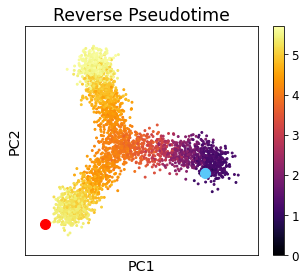

In [34]:
#Here we take the `end_cell` row of `DPT`
ax = scprep.plot.scatter2d(data_pca, c = DPT[end_cell], 
                      ticks=None, title='Reverse Pseudotime', 
                      discrete=False, legend=True, label_prefix='PC',
                      figsize=(4.6,4))
# Plot the root cell
ax.scatter(data_pca.loc[root_cell][0], data_pca.loc[root_cell][1], c ='red', s=100, zorder=10)

# Plot the end cell
ax.scatter(data_pca.loc[end_cell][0], data_pca.loc[end_cell][1], color='#5ac8fa', s=100, zorder=10)

#### Plotting forward vs reverse pseudotime

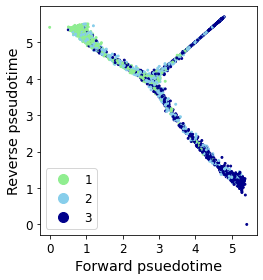

In [35]:
ax = scprep.plot.scatter(DPT[root_cell], DPT[end_cell], 
                         c=sample, cmap=sample_cmap,
                        xlabel='Forward psuedotime',
                        ylabel='Reverse pseudotime')

# resize the axis to avoid distortion between axes
ax.set_aspect(1)

#### Clustering in the forward vs. reverse pseudotime space

Now we have a few options for separating the branches. We could manually bin the cells into groups based on the above plot. However, we can also try to use a clustering algorithm to do this for us.

In [36]:
# Pick your favorite clustering algorithm
clusters = sklearn.cluster.SpectralClustering(n_clusters=3).fit_predict(DPT[[root_cell,end_cell]])

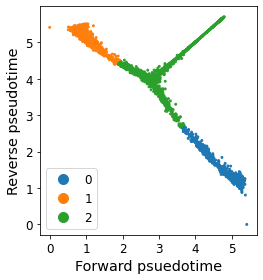

In [37]:
# Plot clusters
ax = scprep.plot.scatter(DPT[root_cell], DPT[end_cell],                          
                         c=clusters,
                         xlabel='Forward psuedotime',
                         ylabel='Reverse pseudotime')
ax.set_aspect(1)

<AxesSubplot:title={'center':'DPT Branch Assignments'}, xlabel='PC1', ylabel='PC2'>

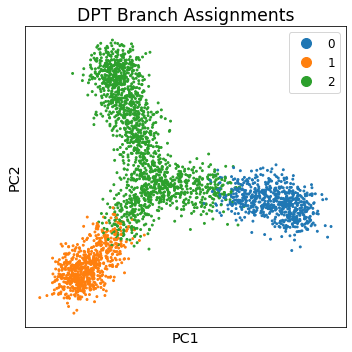

In [38]:
# Plotting the rest of the cells
scprep.plot.scatter2d(data_pca, c=clusters, 
                      title='DPT Branch Assignments',
                      legend=True, label_prefix='PC',
                      ticks=False,
                      figsize=(5,5))

### Discussion

In groups, go back and change:
1. The selection for the root cell (instead of the lowest PC1 value, use the 5th lowest or 10th lowest)
2. The clustering algorithm for branch identification

Answer the following questions:
1. How robust is DPT to selection of root and end cell? How could you quantify this?
    - DPT is extremely robust to this amount of change to the root cell. On the other hand, if we picked the middle value on PC1 we would get very different results. We could quantify this effect by taking the correlation of DPT computed with one root cell vs another.
2. Is there a better clustering algorithm for branch selection than KMeans?
    - It's hard to find a clustering algorithm that perfectly separates these branches using DPT. However, at least on this example, it is easy to segment the tree visually.

## Bonus: Trajectory inference on more complicated trees.

Above we worked on a very simple dataset with only two branches. Below, we've set up parameters to generate a tree with 9 branches. Try running the code and determine:

1. How would you select the root cell?
    - We could pick the root cell based on extremity on PHATE, or by running DPT with a random root cell and then selecting the root cell based on extreme values of DPT.
2. How well does the correlation/anti-correlation work to identify different branches?
    - Not very well, once the number of branches gets large.

#### Generating data with Splatter

In [39]:
# Splatter parameters
# cells_per_path * n_groupsnp.tile(1/n_groups, n_groups)
n_groups = 9
cells_per_path = 300
params = {'method':'paths', 'batch_cells':cells_per_path * n_groups, 'seed':42, 
         'group_prob':np.tile(1/n_groups, n_groups), 'path_from':[0,1,1,2,2,3,3,4,4], 'n_genes':5000,
         'de_fac_loc':0.2}

# Run Splatter
results = scprep.run.SplatSimulate(**params)

# Assign data to data frame
data = pd.DataFrame(results['true_counts'])

# Put metadata in a DataFrame
metadata = pd.DataFrame({'group':results['group'], 'step':results['step'].astype(int)})

# clean up group labels from e.g. Path3 to 3
metadata['group'] = metadata['group'].str[4:].astype(int)



# Reindex
new_index = pd.Index(['cell_{}'.format(i) for i in range(metadata.shape[0])])
data.index = new_index
metadata.index = new_index

data_ln = scprep.normalize.library_size_normalize(data)

R[write to console]: Getting parameters...
R[write to console]: Creating simulation object...
R[write to console]: Simulating library sizes...
R[write to console]: Simulating gene means...
R[write to console]: Simulating path endpoints...
R[write to console]: Simulating path steps...
R[write to console]: Simulating BCV...
R[write to console]: Simulating counts...
R[write to console]: Simulating dropout (if needed)...
R[write to console]: Done!


#### Visualizing with PCA

Given what you know about PCA, why does it perform poorly here?

In [40]:
data_pca = scprep.reduce.pca(np.sqrt(data_ln))

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

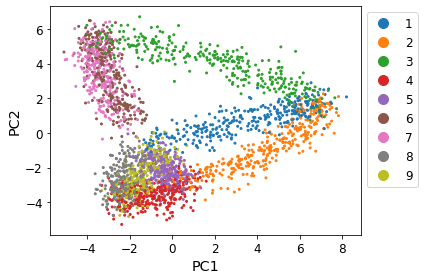

In [41]:
scprep.plot.scatter2d(data_pca, c=metadata['group'], legend_anchor=(1,1))

#### Visualizing with PHATE

In [42]:
phate_op = phate.PHATE()
data_phate = phate_op.fit_transform(data_pca)

Calculating PHATE...
  Running PHATE on 2700 observations and 100 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.81 seconds.
    Calculating affinities...
    Calculated affinities in 0.09 seconds.
  Calculated graph and diffusion operator in 0.91 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.27 seconds.
    Calculating KMeans...
    Calculated KMeans in 8.21 seconds.
  Calculated landmark operator in 9.41 seconds.
  Calculating optimal t...
    Automatically selected t = 6
  Calculated optimal t in 1.20 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.29 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 4.07 seconds.
Calculated PHATE in 15.88 seconds.


In [43]:
data_phate = pd.DataFrame(data_phate, index=data.index)

<AxesSubplot:xlabel='0', ylabel='1'>

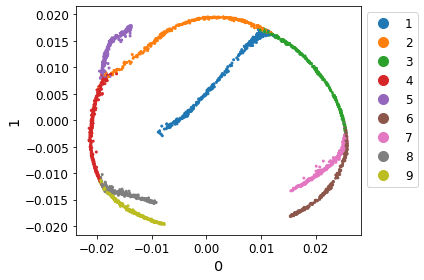

In [44]:
scprep.plot.scatter2d(data_phate, c=metadata['group'], legend_anchor=(1,1))

#### Identifying the root cell

Here we're cheating and using the ground truth to identify this cell. What would you do in a biological dataset?

In [45]:
root_cell = metadata['step'].loc[metadata['group'] == 1].idxmin()

#### Calculating DPT



In [46]:
def calculateDiffusionPseudotime(data):
    '''Calculates DPT between all points in the data'''

    G = gt.Graph(data, n_pca=100, use_pygsp=True)
    
    # Calculate eigenvectors of the diffusion operator
    # May be faster way to do this
    W, V = scipy.sparse.linalg.eigs(G.diff_op, k=1)
    
    # Remove first eigenspace
    T_tilde = G.diff_op.toarray() - (V[:,0] @ V[:,0].T)
    
    # Calculate M
    I = np.eye(T_tilde.shape[1])
    M = np.linalg.inv(I - T_tilde) - I
    M = np.real(M)
    
    # Calc DPT
    DPT = squareform(pdist(M))
    
    DPT = DPT
    return DPT

In [47]:
DPT = calculateDiffusionPseudotime(data)

DPT = pd.DataFrame(DPT, index=data.index, columns=data.index)

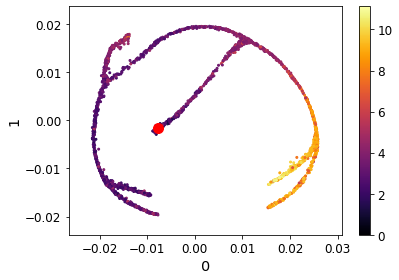

In [48]:
ax = scprep.plot.scatter2d(data_phate, c=DPT[root_cell], legend_anchor=(1,1))
ax.scatter(data_phate.loc[root_cell, 0], data_phate.loc[root_cell, 1], color='red', s=100, zorder=10)

## Calculating reverse pseudotime and branches

Here, you should adapt the code from the **"Calculating branches using correlation anti-correlation"** to calculate reverse pseudotime.

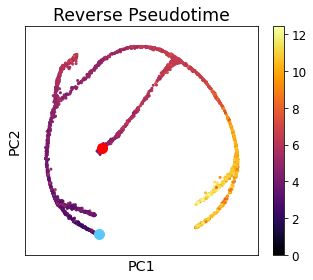

In [49]:
# ========
end_cell = metadata['step'].loc[metadata['group'] == 9].idxmax()



#Here we take the `end_cell` row of `DPT`
ax = scprep.plot.scatter2d(data_phate, c = DPT[end_cell], 
                      ticks=None, title='Reverse Pseudotime', 
                      discrete=False, legend=True, label_prefix='PC',
                      figsize=(4.6,4))
# Plot the root cell
ax.scatter(data_phate.loc[root_cell][0], data_phate.loc[root_cell][1], c ='red', s=100, zorder=10)

# Plot the end cell
ax.scatter(data_phate.loc[end_cell][0], data_phate.loc[end_cell][1], color='#5ac8fa', s=100, zorder=10)


# ========

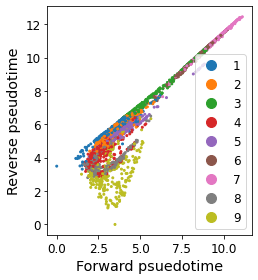

In [50]:
# ========
# Plotting forward vs reverse pseudotime

ax = scprep.plot.scatter(DPT[root_cell], DPT[end_cell], 
                         c=metadata['group'],
                        xlabel='Forward psuedotime',
                        ylabel='Reverse pseudotime')

ax.set_aspect(1)
# ========

<AxesSubplot:xlabel='group', ylabel='cell_194'>

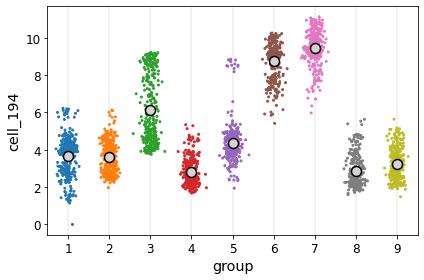

In [51]:
scprep.plot.jitter(metadata['group'], DPT[root_cell],
                   c=metadata['group'], legend=False)

### Discussion

1. What do you notice about the distribution of DPT values in this tree?
    - There are many branches with overlapping DPT values. DPT doesn't do a very good job separating the branches of the tree.
2. What might you do to improve the resolution of the forward/backward pseudotime for branch detection when you have so many branches?
    - We could look at a higher dimensional space by computing DPT from a number of root cells -- e.g., one for every extremity on the PHATE plot.
3. Try adding more or fewer branches. How does this change the resolution of DPT?
    - Fewer branches works well, more branches and things really start to break down.